# TMDB Movie Data Analysis using PySpark

## Initial Setup

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TMDB Movie Analysis") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

# List of movie IDs to analyze
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
             321612, 260513]

# API configuration
API_KEY = "f1ed7ada452dffa6f7d5fb68673be2ee"  # Replace with your actual API key
BASE_URL = "https://api.themoviedb.org/3/movie/"


# Fetch movie Data from API

In [3]:
def fetch_movie_data(movie_id):
    """Fetch movie data from TMDB API for a given movie ID"""
    url = f"{BASE_URL}{movie_id}?api_key={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for movie ID {movie_id}")
        return None

# Fetch data for all movies
movie_data = [fetch_movie_data(mid) for mid in movie_ids if fetch_movie_data(mid) is not None]

# Convert to Pandas DataFrame and then to Spark DataFrame
pdf = pd.DataFrame(movie_data)
movies_df = spark.createDataFrame(pdf)

# Show schema and sample data
print("Schema:")
movies_df.printSchema()
print("\nSample data:")
movies_df.limit(5).show(vertical=True, truncate=False)

Failed to fetch data for movie ID 0
Schema:
root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: map (nullable = true)
 |    |-- key: string
 |    |-- value: long (valueContainsNull = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: long (valueContainsNull = true)
 |-- homepage: string (nullable = true)
 |-- id: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- origin_country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 


# Data Cleaning and Preprocessing

In [4]:
## Data Cleaning and Preprocessing 
from pyspark.sql.functions import col, when, expr, to_date, concat_ws, array_join, split

# Drop irrelevant columns
cols_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
movies_clean = movies_df.drop(*cols_to_drop)

# Define functions to process JSON columns correctly
def process_collection(col):
    """Extract collection name from JSON"""
    return when(
        col.isNull(), 
        None
    ).otherwise(
        expr("belongs_to_collection.name")
    ).alias("belongs_to_collection")

def process_json_array(col_name, field='name'):
    """Extract names from JSON array and join with |"""
    return array_join(
        expr(f"transform({col_name}, x -> x.{field})"),
        "|"
    ).alias(col_name)

# Process JSON-like columns
movies_clean = movies_clean.withColumn(
    "belongs_to_collection", 
    process_collection(col("belongs_to_collection"))
).withColumn(
    "genres", 
    process_json_array("genres")
).withColumn(
    "production_companies", 
    process_json_array("production_companies")
).withColumn(
    "production_countries", 
    process_json_array("production_countries", 'iso_3166_1')
).withColumn(
    "spoken_languages", 
    process_json_array("spoken_languages", 'iso_639_1')
)

# Convert data types
movies_clean = movies_clean.withColumn("budget", col("budget").cast("double")) \
    .withColumn("revenue", col("revenue").cast("double")) \
    .withColumn("popularity", col("popularity").cast("double")) \
    .withColumn("vote_count", col("vote_count").cast("integer")) \
    .withColumn("vote_average", col("vote_average").cast("double")) \
    .withColumn("release_date", to_date(col("release_date"), "yyyy-MM-dd"))

# Handle missing/incorrect values
movies_clean = movies_clean.withColumn("budget", 
    when((col("budget") == 0) | (col("budget").isNull()), None).otherwise(col("budget"))) \
    .withColumn("revenue", 
    when((col("revenue") == 0) | (col("revenue").isNull()), None).otherwise(col("revenue"))) \
    .withColumn("runtime", 
    when((col("runtime") == 0) | (col("runtime").isNull()), None).otherwise(col("runtime"))) \
    .withColumn("vote_average", 
    when(col("vote_count") == 0, None).otherwise(col("vote_average"))) \
    .withColumn("tagline", 
    when((col("tagline") == "") | (col("tagline").isNull()), None).otherwise(col("tagline"))) \
    .withColumn("overview", 
    when((col("overview") == "") | (col("overview").isNull()), None).otherwise(col("overview")))

# Convert budget and revenue to million USD
movies_clean = movies_clean.withColumn("budget_musd", col("budget") / 1000000) \
    .withColumn("revenue_musd", col("revenue") / 1000000)

# Filter only released movies
movies_clean = movies_clean.filter(col("status") == "Released").drop("status")

# Reorder columns as specified
final_columns = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 
    'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 
    'overview', 'spoken_languages', 'poster_path'
]

movies_final = movies_clean.select(*final_columns)

# Show cleaned data
print("Cleaned data schema:")
movies_final.printSchema()
print("\nSample cleaned data:")
movies_final.limit(5).show(vertical=True, truncate=False)

Cleaned data schema:
root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- genres: string (nullable = true)
 |-- belongs_to_collection: long (nullable = true)
 |-- original_language: string (nullable = true)
 |-- budget_musd: double (nullable = true)
 |-- revenue_musd: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- runtime: long (nullable = true)
 |-- overview: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)


Sample cleaned data:
-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------


# KPI Implementation and Analysis

In [5]:
# Define a ranking function
def rank_movies(df, metric, ascending=False, min_budget=None, min_votes=None):
    """Rank movies based on specified metric with optional filters"""
    df_filtered = df
    if min_budget is not None:
        df_filtered = df_filtered.filter(col("budget_musd") >= min_budget)
    if min_votes is not None:
        df_filtered = df_filtered.filter(col("vote_count") >= min_votes)
    
    return df_filtered.orderBy(metric, ascending=ascending)

# Calculate profit and ROI
movies_analysis = movies_final.withColumn("profit_musd", col("revenue_musd") - col("budget_musd")) \
    .withColumn("roi", col("revenue_musd") / col("budget_musd"))

# 1. Identify Best/Worst Performing Movies
print("\nHighest Revenue Movies:")
rank_movies(movies_analysis, "revenue_musd").select("title", "revenue_musd").show(5)

print("\nHighest Budget Movies:")
rank_movies(movies_analysis, "budget_musd").select("title", "budget_musd").show(5)

print("\nHighest Profit Movies:")
rank_movies(movies_analysis, "profit_musd").select("title", "profit_musd").show(5)

print("\nLowest Profit Movies:")
rank_movies(movies_analysis, "profit_musd", ascending=True).select("title", "profit_musd").show(5)

print("\nHighest ROI Movies (Budget ≥ $10M):")
rank_movies(movies_analysis, "roi", min_budget=10).select("title", "roi", "budget_musd").show(5)

print("\nLowest ROI Movies (Budget ≥ $10M):")
rank_movies(movies_analysis, "roi", ascending=True, min_budget=10).select("title", "roi", "budget_musd").show(5)

print("\nMost Voted Movies:")
rank_movies(movies_analysis, "vote_count").select("title", "vote_count").show(5)

print("\nHighest Rated Movies (≥10 votes):")
rank_movies(movies_analysis, "vote_average", min_votes=10).select("title", "vote_average", "vote_count").show(5)

print("\nLowest Rated Movies (≥10 votes):")
rank_movies(movies_analysis, "vote_average", ascending=True, min_votes=10).select("title", "vote_average", "vote_count").show(5)

print("\nMost Popular Movies:")
rank_movies(movies_analysis, "popularity").select("title", "popularity").show(5)

# 2. Franchise vs. Standalone Movie Performance
franchise_stats = movies_analysis.groupBy(col("belongs_to_collection").isNotNull().alias("is_franchise")) \
    .agg(
        avg("revenue_musd").alias("mean_revenue"),
        expr("percentile_approx(roi, 0.5)").alias("median_roi"),
        avg("budget_musd").alias("mean_budget"),
        avg("popularity").alias("mean_popularity"),
        avg("vote_average").alias("mean_rating")
    ).orderBy("is_franchise")

print("\nFranchise vs Standalone Performance:")
franchise_stats.show()

# 3. Most Successful Franchises
franchise_analysis = movies_analysis.filter(col("belongs_to_collection").isNotNull()) \
    .groupBy("belongs_to_collection") \
    .agg(
        count("*").alias("movie_count"),
        sum("budget_musd").alias("total_budget"),
        avg("budget_musd").alias("mean_budget"),
        sum("revenue_musd").alias("total_revenue"),
        avg("revenue_musd").alias("mean_revenue"),
        avg("vote_average").alias("mean_rating")
    ).orderBy(col("total_revenue").desc())

print("\nMost Successful Franchises:")
franchise_analysis.show(5)


Highest Revenue Movies:
+--------------------+------------+
|               title|revenue_musd|
+--------------------+------------+
|              Avatar| 2923.706026|
|   Avengers: Endgame|   2799.4391|
|             Titanic| 2264.162353|
|Star Wars: The Fo...| 2068.223624|
|Avengers: Infinit...| 2052.415039|
+--------------------+------------+
only showing top 5 rows


Highest Budget Movies:
+--------------------+-----------+
|               title|budget_musd|
+--------------------+-----------+
|Avengers: Age of ...|      365.0|
|   Avengers: Endgame|      356.0|
|Avengers: Infinit...|      300.0|
|       The Lion King|      260.0|
|Star Wars: The Fo...|      245.0|
+--------------------+-----------+
only showing top 5 rows


Highest Profit Movies:
+--------------------+------------------+
|               title|       profit_musd|
+--------------------+------------------+
|              Avatar|       2686.706026|
|   Avengers: Endgame|         2443.4391|
|             Titanic|      


# Data Visualization

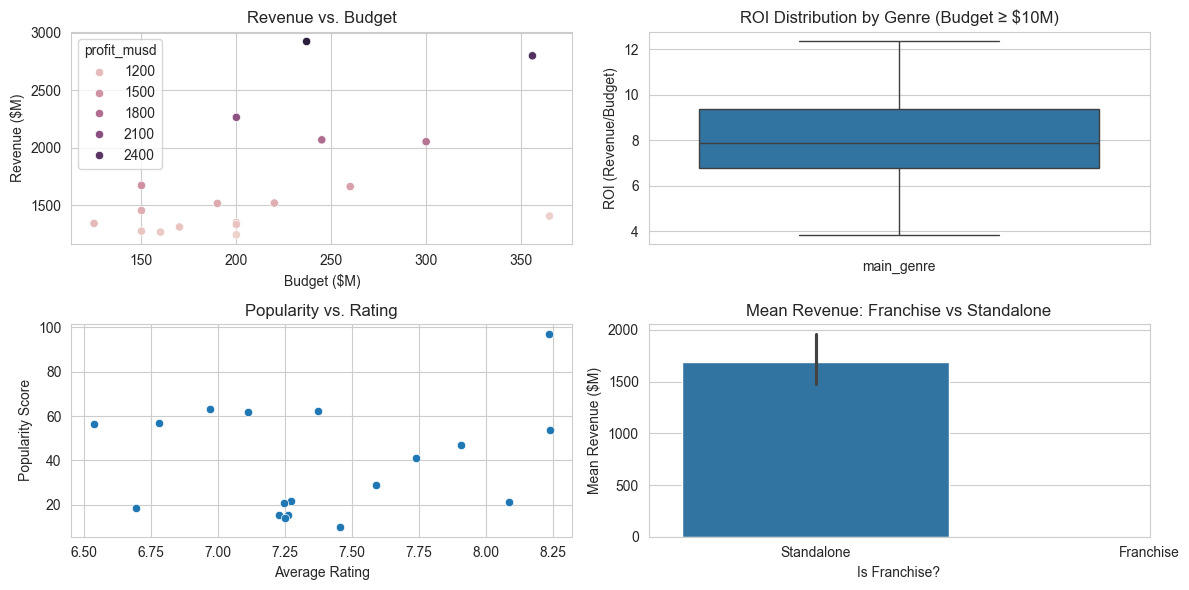

In [6]:
# Convert relevant data to Pandas for visualization
viz_df = movies_analysis.select(
    "title", "release_date", "genres", "budget_musd", 
    "revenue_musd", "profit_musd", "roi", "vote_average", 
    "popularity", "belongs_to_collection"
).toPandas()

# Set style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Revenue vs. Budget
plt.subplot(2, 2, 1)
sns.scatterplot(data=viz_df, x="budget_musd", y="revenue_musd", hue="profit_musd")
plt.title("Revenue vs. Budget")
plt.xlabel("Budget ($M)")
plt.ylabel("Revenue ($M)")

# ROI Distribution by Genre
plt.subplot(2, 2, 2)
viz_df['main_genre'] = viz_df['genres'].str.split('|').str[0]
sns.boxplot(data=viz_df[viz_df['budget_musd'] >= 10], x="main_genre", y="roi")
plt.title("ROI Distribution by Genre (Budget ≥ $10M)")
plt.xticks(rotation=45)
plt.ylabel("ROI (Revenue/Budget)")

# Popularity vs. Rating
plt.subplot(2, 2, 3)
sns.scatterplot(data=viz_df, x="vote_average", y="popularity")
plt.title("Popularity vs. Rating")
plt.xlabel("Average Rating")
plt.ylabel("Popularity Score")

# Franchise vs Standalone Comparison
plt.subplot(2, 2, 4)
viz_df['franchise'] = viz_df['belongs_to_collection'].notna()
sns.barplot(data=viz_df, x="franchise", y="revenue_musd", estimator="mean")
plt.title("Mean Revenue: Franchise vs Standalone")
plt.xlabel("Is Franchise?")
plt.ylabel("Mean Revenue ($M)")
plt.xticks([0, 1], ["Standalone", "Franchise"])

plt.tight_layout()
plt.show()